<a href="https://colab.research.google.com/github/Kirikuna/Proyecto-ML/blob/main/ProyectoConProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Descarga e Incialización de los datos a procesar** 

Con el link, guardado en la varible *url*, obtenemos el archivo con la información correspondiente. 

El archivo que se descargó en *url*, lo transformamos en un DataFrame con *pandas* con las siguientes configuraciones:



*  ` skiprow=1`; se quita la primera fila de información que contiene los encabezados.
*   `parse_dates=[1]`; tranforma a fecha la segunda columna, o eso debería hacer, pues lo que hace (para el caso de la columna *hour*) es agregar el 0 al principio del número de cada hora en la columna, conveniente para después tranformar la fecha completa (fecha y hora).
*  ` sep=';'`; se le define el tipo de separador del archivo .csv descargado.
*   `names=[...]`; se definen los nuevos nombres de las columnas respectivas.
*   `decimal=','`; los datos númericos vienen escritos con una *coma (,)* en vez de un punto para definir los decimales, este parámetro define lo explicado.

Luego hacemos una unión de las columnas *date* y *hour* en una nueva columna llamada *Date*, para definir la fecha completa y luego transformala.



In [ ]:
import pandas as pd
import numpy as np
url = 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
df = pd.read_csv(url, skiprows=1, parse_dates=[1], sep=';', names=['date', 'hour', 'validated', 'preliminary', 'no validated', 'NA'], decimal=',')
df.insert(0, 'Date', df["date"].map(str) + df["hour"].map(str))
df.head()

,Date,date,hour,validated,preliminary,no validated,NA
0,1207070100,120707,0100,NaN,NaN,NaN,NaN
1,1207070200,120707,0200,NaN,NaN,NaN,NaN
2,1207070300,120707,0300,NaN,NaN,NaN,NaN
3,1207070400,120707,0400,NaN,NaN,NaN,NaN
4,1207070500,120707,0500,NaN,NaN,NaN,NaN


## Transformación de Fechas

Las fechas contenidas en la columna *Date* se parsean entregandolé el formato en el que se encuentra nuestra fecha actualmente.

Luego, se eliminan la columnas que no volveremos a usar.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format="%y%m%d%H%M")
df.drop(['date', 'hour', 'NA'], axis = 'columns', inplace=True)
df.head(5)

,Date,validated,preliminary,no validated
0,2012-07-07 01:00:00,NaN,NaN,NaN
1,2012-07-07 02:00:00,NaN,NaN,NaN
2,2012-07-07 03:00:00,NaN,NaN,NaN
3,2012-07-07 04:00:00,NaN,NaN,NaN
4,2012-07-07 05:00:00,NaN,NaN,NaN


## Adaptación de columnas con valores

> Las series de tiempo deben tener 2 columnas, una con el tiempo y otra con el valor medido en ese instante. Lo que nos toca ahora, es reducir a una sola columna todas las columnas de registros (validated, preliminary, no validated).

> Observando los datos sin procesar, podemos ver que si, en un instante de tiempo particular, una columna tiene un valor registrado (un registro), las otras 2 columnas no lo tendrán. Aprovechando eso,  hacemos una sumatoria de cada fila a partir de esas 3 columnas, y eso lo guardamos en una nueva columna (register) en el mismo DataFrame.

>Un consideración que podriammos tener, es que, tal vez, solo deberíamos usar los datos validados, pues estamos seguros de su autenticidad. Pero si hacemos eso nos quedamos sin datos. Además, si están o no verificados, sirven como datos de entrenamiento igualmente. 

In [ ]:
columns = ['validated', 'preliminary', 'no validated']
df['registers'] = df[columns].sum(axis=1)
df.head(5)

,Date,validated,preliminary,no validated,registers
0,2012-07-07 01:00:00,NaN,NaN,NaN,0.0
1,2012-07-07 02:00:00,NaN,NaN,NaN,0.0
2,2012-07-07 03:00:00,NaN,NaN,NaN,0.0
3,2012-07-07 04:00:00,NaN,NaN,NaN,0.0
4,2012-07-07 05:00:00,NaN,NaN,NaN,0.0


## Eliminación de columnas

Se eliminan las colmnas que no se volverán a usar por el resto de la aplicación. En este caso, hablo de las columnas referentes a los registros.

In [ ]:
df.drop(columns, axis = 'columns', inplace=True)
df.head()

,Date,registers
0,2012-07-07 01:00:00,0.0
1,2012-07-07 02:00:00,0.0
2,2012-07-07 03:00:00,0.0
3,2012-07-07 04:00:00,0.0
4,2012-07-07 05:00:00,0.0


## Calculo de promedio diario

>Las predicciones de contaminación, normalmente, se hacen con los promedios diarios de los registros hechos cada hora. Por lo que, en esta sección, se calculan los promedios diarios de contaminación.

>Cabe decir, que se trató de aplicar el modelo sin este paso, pero generaba predicciones poco convincentes. Esto se lo atribuyo a la cantidad tan grande de datos que debía procesar Prophet, ya que por día eran 24 datos más como máximo, por varios años. En este caso son 365 datos por año, muchísimo menos. Un poco adelante profundizaremos más.

In [ ]:
data = df.resample('D', on='Date').mean()
df = pd.DataFrame(data.reset_index())
df.head()

,Date,registers
0,2012-07-07,74.021291
1,2012-07-08,121.817817
2,2012-07-09,36.074992
3,2012-07-10,28.607624
4,2012-07-11,95.962415


## Correción de la información

>Aun con el promedio anterior realizado (el cual se quitaba muchos datos de encima) pueden quedar celdas de columnas sin información, así que se deben de corregir.

>En este caso, se decantó por rellenar esos espacios vacios con el promedio de la información de la columna. Se toma esta decisión porque prefiero que existan unos pocos datos incongruentes, a perder la continuidad de las fechas en la Serie de tiempo y que, por lo tanto, existan vacios de días.

>Tal vez hubiese sido mejor rellenar esos espacios con los promedios móviles de los días que no tuviesen información, pero no supe como hacerlo.

>También se eliminan todos lo datos anteriores a 2015 por ser demasiado incongruentes con el resto de la medición.

In [ ]:
column = 'registers'
df[column] = df[column].replace(0, np.NaN)
mean = int(df[column].mean(skipna=True))
df[column] = df[column].replace(np.NaN, mean)
df = df[(df['Date'] >= '2015-01-01')]

df.head()

,Date,registers
908,2015-01-01,7.333333
909,2015-01-02,9.625000
910,2015-01-03,10.875000
911,2015-01-04,13.999411
912,2015-01-05,12.940171


## Trend, Seasonal y Residual



*   Trend: 
> En la gráfica de tendencia podemos observar que desde 2015 hasta 2019 la contaminación del aire tiende a disminuir, con un leve aumento a mediados de 2019, pero continúa bajando.


*   Seasonal:
> La estacionalidad observada es parecida a una función senoidal, un poco más erratica, pero que respeta muy bien lo que se puede rescatar a simple vista de la gráfica de los datos.

*   Residual:
> Se puede observar los datos discordantes con respecto a la tendencia, ni la estacionalidad.





/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


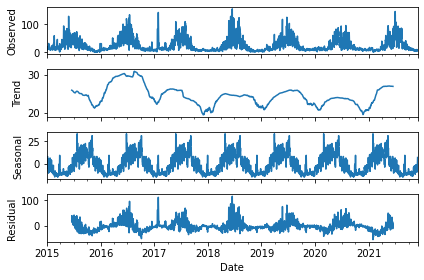

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    df.set_index("Date").registers.interpolate("linear"),
    freq=12*4*7,
    model='aditive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()

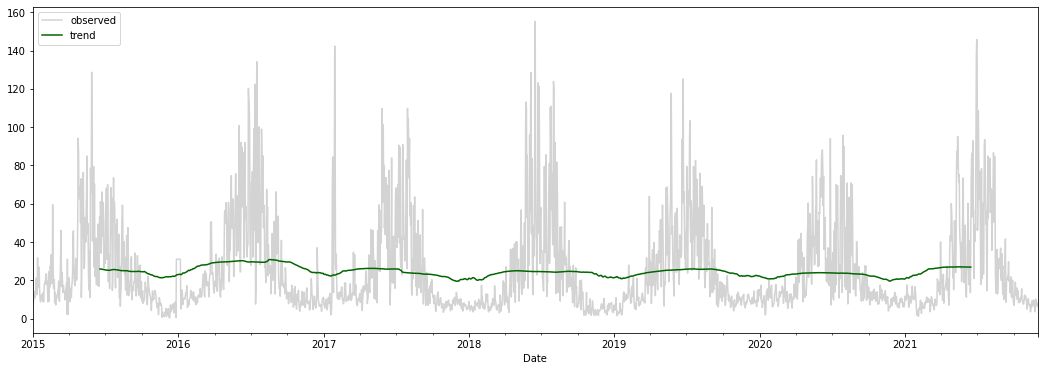

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="Date", y="registers", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend", color="darkgreen")
plt.legend(loc='upper left')

plt.savefig('trend.png');

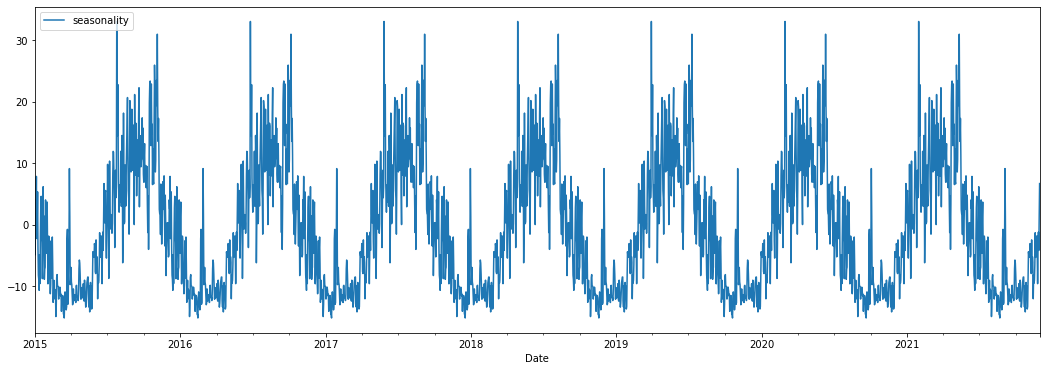

In [ ]:
fig, ax = plt.subplots(figsize=(18,6)) 
seasonal.plot(ax=ax, label="seasonality")
plt.legend(loc='upper left')

plt.savefig('seasonal.png');

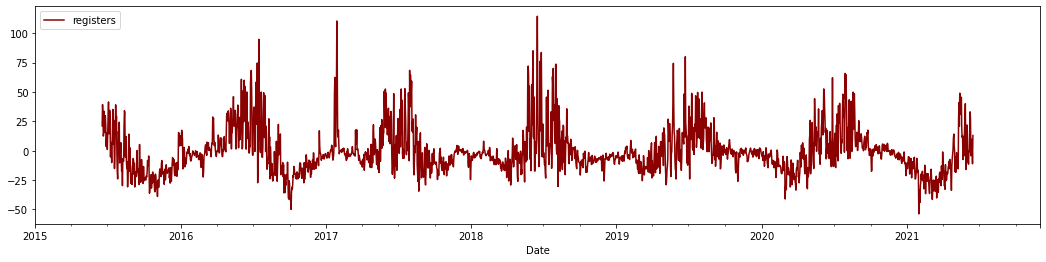

In [ ]:
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality", color="darkred")
plt.legend(loc='upper left')

plt.savefig('residual.png');

## Datos de testing y fechas importantes

*    Testing y Training:
> Se considerará datos de prueba todos los días del año 2021 y como entrenamiento de 2015-2021

*    Fecha Importante:
> En 2017 se puede ver que a inicios de ese año hay un despunte que no se encuentra en ningún otro verano de enero de los otros años. Investigando, y recordando, pude dar con el hecho que azotaba a la zona centro sur del país en ese momento. Ese despunte tan grande y significativo era resultado de los constantes incendios sufridos en esta región del país, que duró varias semanas.

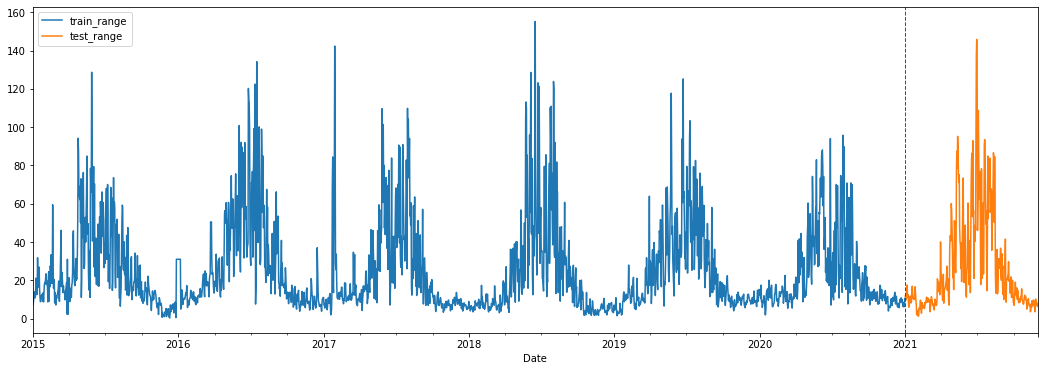

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
train_range = df[(df['Date'] < '2021-01-01')].index
test_range = df[(df['Date'] >= '2021-01-01')].index
#print(df.loc[train_range])
df.loc[train_range].plot(x="Date", y="registers", ax=ax, label="train_range")
df.loc[test_range].plot(x="Date", y="registers", ax=ax, label="test_range")

plt.axvline(pd.to_datetime(str(df["Date"].loc[test_range].values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('visualization.png');

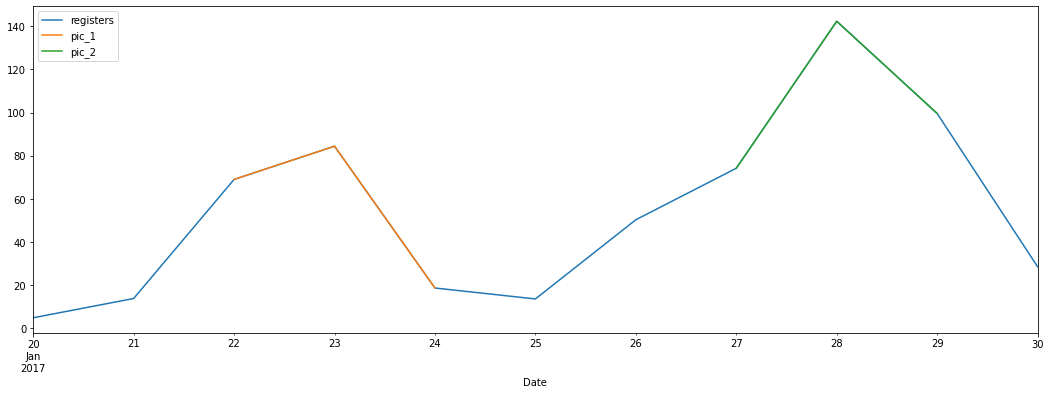

In [ ]:
date_range = df[(df['Date'] > '2017-01-19') & (df['Date'] <= '2017-01-30')].index
imp_hour_1 = df[(df['Date'] >= '2017-01-22') & (df['Date'] <= '2017-01-24')].index
imp_hour_2 = df[(df['Date'] >= '2017-01-27') & (df['Date'] <= '2017-01-29')].index

fig, ax = plt.subplots(figsize=(18,6)) 
df.loc[date_range].plot(x="Date", y="registers", ax=ax)
df.loc[imp_hour_1].plot(x="Date", y="registers", ax=ax, label="pic_1")
df.loc[imp_hour_2].plot(x="Date", y="registers", ax=ax, label="pic_2")
plt.legend(loc='upper left')

plt.savefig('important_date.png');

## Prophet

> Se obtienen los feriados de cada año registrado para luego ser considerados por el modelo Prophet en la evaluación. También, se hace anotación de los dos hitos más relevantes que se pueden ver en el gráfico.

> Ahora inicializamos el modelo de Prophet con los siguiente, más importantes, parámetros:
*   `yearly_seasonality=True`; dada la gráfica de estacionalidad vista con anterioridad, podemos decir que si hay estacionalidad anual.
*   `weekly_seasonality=True`; ya que los datos corregidos consideran los días, es normal pensar que hay estacionalidad semanal.
*   `daily_seasonality=False`; se desactiva porque los datos horarios se promediaron para crear datos diarios.
*    `mcmc_samples=7*4`; se usan muestras cada 7 días y 4 semanas, básicamente un mes. Aquí vemos la importancia de haber reducido los datos horarios a diarios, puesto que si hubiesen sido del primer tipo la cantidad de muestras que debe examinar para considerar un mes hubisen sido de: `24(horas)*7(días)*4`(semanas), siendo una carga muy grande para Prophet.
*    `growth='linear'`; se condisera un crecimiento linea por lo conversado en la sección **Trend, Seasonal y Residual**.

In [ ]:
import holidays
years = range(2015, 2022)

cl_holidays = holidays.CL(years=years)

df_holidays = pd.DataFrame.from_dict(cl_holidays, orient="index").reset_index()
df_holidays.columns = ["ds", "holiday"]

In [ ]:
from datetime import date

changepoints = {
    date(2017,1,22): "Incendio masivo en la zona centro sur del país",
    date(2017,1,28): "Incendio masivo en la zona centro sur del país"
}

In [ ]:
from fbprophet import Prophet
df_prophet_train = df.loc[train_range][["Date", "registers"]]
df_prophet_train.columns = ["ds", "y"]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoints=list(changepoints.keys()),
    holidays=df_holidays,
    mcmc_samples=7*4,
    growth='linear',
    interval_width=0.9)

model.fit(df_prophet_train);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


>Vemos que la tendencia de los datos entrenados es hacia la baja. Esto ya lo habíamos discutido, pero ahora es confirmado por la gráfica que entrega el modelo de Prophet.

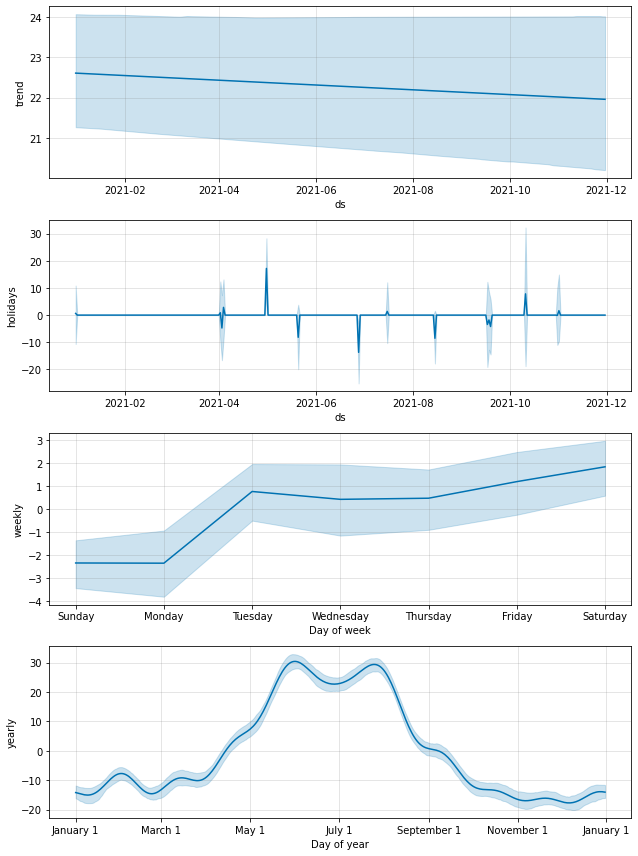

In [ ]:
df_prophet_test = df.loc[test_range][["Date", "registers"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df.loc[test_range].registers.values

fig = model.plot_components(forecast)

## Resultados

> Luego de todo el recorrido realizado, ahora podemos observar los resultados de la predicción hecha por Prophet. 

> Viendo la predicción, lo primero que nos damos cuenta es que la línea roja no es igual ni parecida a la azul (tramo de 2021 a 2022). Esto puede indicar que el modelo falló en su predicción, lo cual es cierto, pero no falló sin ninguna explicación.

> Si volvemos a observar la tendencia de la contaminación, dijimos que la gráfica estaba en constante decrecimiento al pasar los años, respecto a la temporada de mayor contaminación. Entonces, con esto presente, podemos decir que Prophet trató de predecir con este precedente y por eso tal resultado, dónde, supuestamente, el año 2021 tendría menor contaminación, pero no fue el caso.

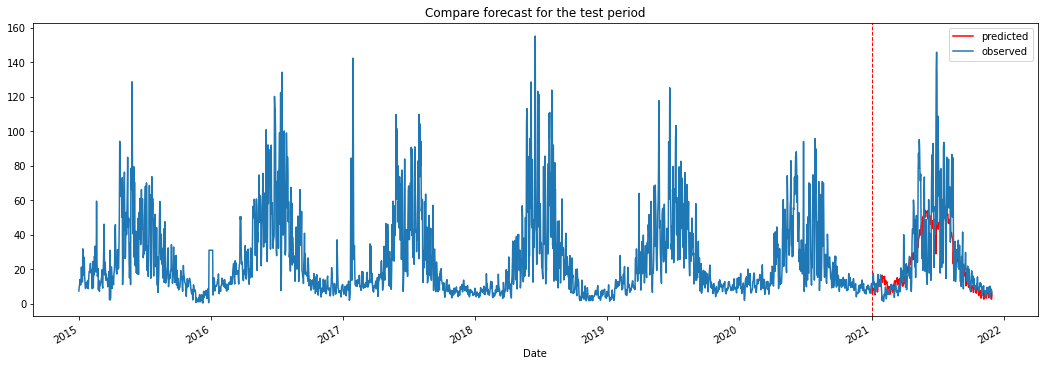

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].Date.values), yhat_test, color="red", label="predicted")

plt.axvline(pd.to_datetime(str(df.loc[test_range].Date.values[0])), c='red', ls='--', lw=1)
df.plot(x="Date", y="registers", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.savefig('prophet-forecast-testrange.png')
plt.show();

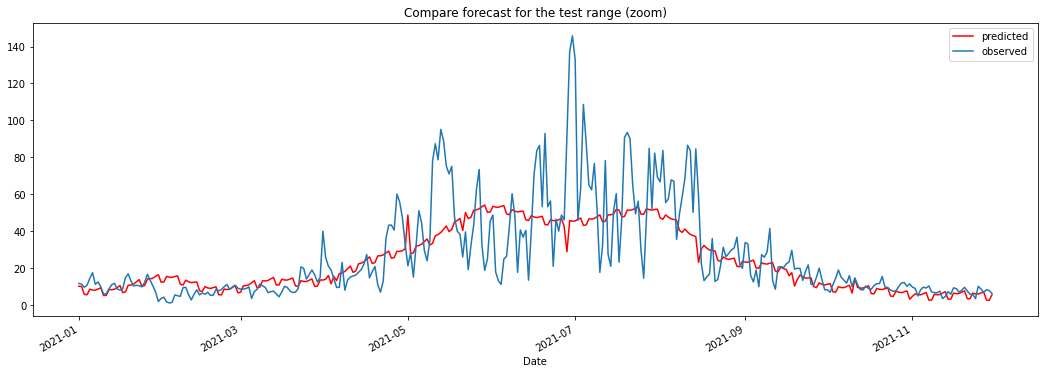

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].Date.values), yhat_test,
        color="red", label="predicted")

df.loc[test_range].plot(x="Date", y="registers", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')


plt.savefig('prophet-forecast-testrange-zoom.png')
plt.show();

## Errores

> *   MAE: Da un error bastante bajo, considerando la diferencia entre los picos más altos.

> *     MSE: Con este error podemos observar más claramente la diferecia entre los valores predichos y los reales, puesto que es mucho más alto que el anterio error, ya que le otorga mayor importancia a los errores más grandes.

> *     R2: Tenemos un R^2 intermedio, que indica que no se ajustó mucho ni se alejó mucho de la realidad de los datos.

>*     U: El coeficiente de incertidumbre indica que conocer el valor de la varible, en este caso, no es muy útil pues solo asegura que no tendrá un error de 0.017, el cual es muy bajó. No podemos asegurar que no halla fallado la predicción, por lo que entrega esta variable.



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

In [ ]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

MAE (test): 11
MSE (test): 333
R2  (test): 0.503
U   (test): 0.016862


## Conclusión

> Para resumir el trabajo, podemos decir que Prophet hizo predicciones comprensibles dada la naturaleza de los datos, pero que no se acercaron lo suficiente con lo que es la realidad.

> También, debemos mencionar el hecho de que Prophet trabaja muchísimo mejor con datos diarios que horarios, pues la carga que recibe Prophet es mucho menor con el primer tipo de datos que con el segundo, y, dada mi experiencia, eso es muy importante para el modelo, ya que no soporta una cantidad de muestras muy grande en el parámetro `mcmc_samples`; no es lo mismo considerar un mes con datos diarios (30 muestras aprox.), que considerar ese mismo mes con datos horarios (720 aprox.).